In [1]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

# 获取可用的 GPU 设备列表
gpus = tf.config.experimental.list_physical_devices('GPU')


# # 如果没有可用的 GPU 设备，则输出错误信息
# if not gpus:
#     print("No available GPU devices!")
# else:
#     # 输出可用的 GPU 设备信息
#     for gpu in gpus:
#         print(gpu)
# # 指定使用的 GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_visible_devices(gpus[0], 'GPU')


2023-04-03 21:02:27.662819: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 21:02:27.670198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 21:02:27.670424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# 定义超参数
lr = 0.001
batch_size = 256
num_epochs = 100

# 定义卷积神经网络模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', input_shape=(32, 32, 3)), # 输入通道数为3，输出通道数为64，卷积核大小为3x3，填充为1
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为64，输出通道数为64，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.05),
    
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'), # 输入通道数为64，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为128，输出通道数为128，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    # 设置 kernel_regularizer 参数来实现 L2 正则化。其中 0.001 是 L2 正则化系数。
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), # 输入通道数为128，输出通道数为256，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'), 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)), # 输入通道数为256，输出通道数为256，卷积核大小为3x3，填充为1
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), # 最大池化层，大小为2x2，步幅为2
    tf.keras.layers.Dropout(0.15),
    
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2), 
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(), # 将张量展开为一维张量
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1024, activation='relu'), # 全连接层1，输入维度为256*4*4，输出维度为1024
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)), # 全连接层2，输入维度为1024，输出维度为512
    tf.keras.layers.Dense(10, activation='softmax') # 输出层，输入维度为512，输出维度为10
])

2023-04-03 21:02:27.725881: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 21:02:27.726721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 21:02:27.726987: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-03 21:02:27.727132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
# 定义训练集和测试集的数据增强
train_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

test_transform = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [4]:
def lr_schedule(epoch, lr):
    if epoch % 20 == 0 and epoch > 0:
        lr = lr / 2
    return lr
#定义动态学习率调整机制
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# 加载 CIFAR-10 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 将标签转换为 one-hot 编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# 对训练集和测试集的特征进行数据增强和标准化处理
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.map(lambda x, y: (train_transform(x), y))
train_dataset = train_dataset.batch(batch_size=batch_size)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(lambda x, y: (test_transform(x), y))
test_dataset = test_dataset.batch(batch_size=batch_size)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 定义优化器和损失函数
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# 定义回调函数，保存最佳模型
checkpoint_path = 'final_best.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# 编译模型
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# 训练模型
history = model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset,callbacks=[checkpoint,lr_scheduler])

Epoch 1/100


2023-04-03 21:02:33.962240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-04-03 21:02:36.403859: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


196/196 [==============================] - ETA: 0s - loss: 4.3978 - accuracy: 0.2252
Epoch 00001: val_accuracy improved from -inf to 0.09870, saving model to my_model_final_best.h5
196/196 [==============================] - 60s 279ms/step - loss: 4.3978 - accuracy: 0.2252 - val_loss: 4.0989 - val_accuracy: 0.0987 - lr: 0.0010
Epoch 2/100
196/196 [==============================] - ETA: 0s - loss: 2.6872 - accuracy: 0.3498
Epoch 00002: val_accuracy improved from 0.09870 to 0.14390, saving model to my_model_final_best.h5
196/196 [==============================] - 55s 280ms/step - loss: 2.6872 - accuracy: 0.3498 - val_loss: 4.1186 - val_accuracy: 0.1439 - lr: 0.0010
Epoch 3/100
196/196 [==============================] - ETA: 0s - loss: 2.0293 - accuracy: 0.4556
Epoch 00003: val_accuracy improved from 0.14390 to 0.33690, saving model to my_model_final_best.h5
196/196 [==============================] - 53s 272ms/step - loss: 2.0293 - accuracy: 0.4556 - val_loss: 2.4873 - val_accuracy: 0.3369

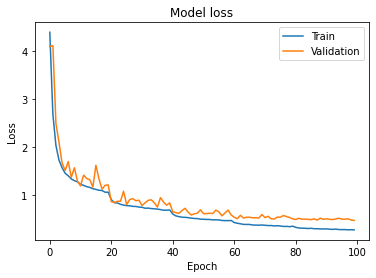

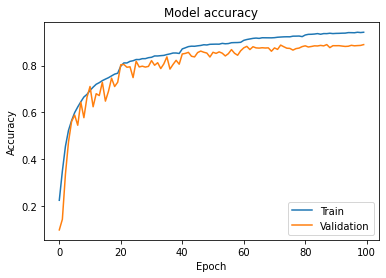

In [5]:
# 可视化显示训练集和测试集的loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# 可视化显示训练集和测试集的accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [6]:
model.save('final_final.h5') # 保存为.h5格式

In [7]:
# 读取模型
model = load_model('final_best.h5')

# 进行测试
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy:', test_acc)

40/40 [==============================] - 1s 12ms/step - loss: 0.4724 - accuracy: 0.8898
Test accuracy: 0.8898000121116638


Class 0：airplane accuracy: 90.70%
Class 1：automobile accuracy: 96.30%
Class 2：bird accuracy: 86.30%
Class 3：cat accuracy: 78.30%
Class 4：deer accuracy: 87.10%
Class 5：dog accuracy: 79.40%
Class 6：frog accuracy: 95.60%
Class 7：horse accuracy: 90.80%
Class 8：ship accuracy: 92.30%
Class 9：truck accuracy: 93.00%


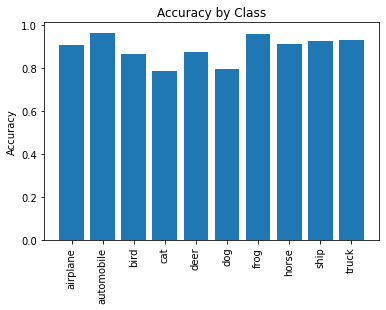

In [8]:
# 加载 CIFAR-10 数据集
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# 将标签转换为 one-hot 编码
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 预测测试集的标签
y_pred = model.predict(test_dataset)

# 计算每个类别的准确率
correct_counts = [0] * 10
total_counts = [0] * 10
for i in range(len(y_pred)):
    pred_label = tf.argmax(y_pred[i]).numpy()
    true_label = tf.argmax(y_test[i]).numpy()
    total_counts[true_label] += 1
    if pred_label == true_label:
        correct_counts[true_label] += 1

# 打印每个类别的准确率
for i in range(10):
    acc = correct_counts[i] / total_counts[i]
    print('Class {}：{} accuracy: {:.2%}'.format(i, class_names[i] ,acc))
    
# 可视化每个类别的准确率
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
accuracies = [correct_counts[i] / total_counts[i] for i in range(10)]
x_pos = np.arange(len(class_names))
plt.bar(x_pos, accuracies)
plt.xticks(x_pos, class_names, rotation='vertical')
plt.ylabel('Accuracy')
plt.title('Accuracy by Class')
plt.show()

Confusion matrix, without normalization
[[907   8  23   5   5   1   3   2  25  21]
 [  2 963   0   1   0   1   1   0   8  24]
 [ 13   1 863  24  21  23  38  12   2   3]
 [ 13   1  24 783  26  78  45  13   7  10]
 [  5   1  25  25 871  24  31  17   1   0]
 [  8   1  22  99  20 794  32  16   2   6]
 [  1   1  13  14   5   2 956   2   1   5]
 [ 16   1   9  16  22  20   2 908   1   5]
 [ 38  14   6   2   2   0   1   0 923  14]
 [  9  44   1   4   1   1   4   0   6 930]]


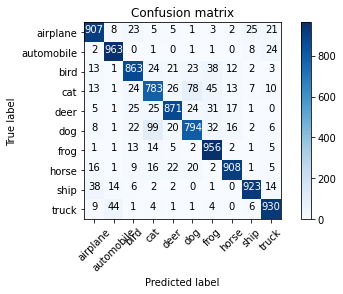

In [9]:
# 预测测试集的结果
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# 计算混淆矩阵
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, class_names)